In [35]:
import linopy
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path
from shapely import wkt
import numpy as np

In [36]:
coarsenscale = 5
lccs_resolution = 300 * coarsenscale #m
areapergrid = (lccs_resolution/1000) ** 2 ## km2

mwperkm2_wind = 4.5 ## originally 9 MW/km2 but deduct by 50% of the technically available from IEA's Thailand CET
mwperkm2_solar = 15 ## originally 30 MW/km2 but deduct by 50% of the technically available from IEA's Thailand CET

mwpergrid_wind = np.round(areapergrid * mwperkm2_wind,2)
mwpergrid_solar =  np.round(areapergrid * mwperkm2_solar,2)

print('areapergrid = ',areapergrid)
print('mwpergrid_wind = ',mwpergrid_wind)
print('mwpergrid_solar = ',mwpergrid_solar)

maxcapacityfor_spp = 90
maxcapacityfor_vspp = 10

rollingwindow_spp_wind = int(np.ceil(np.sqrt(maxcapacityfor_spp/mwpergrid_wind)))
if ( rollingwindow_spp_wind % 2 == 0 ) : rollingwindow_spp_wind += 1
rollingwindow_vspp_wind = int(np.ceil(np.sqrt(maxcapacityfor_vspp/mwpergrid_wind)))
if ( rollingwindow_vspp_wind % 2 == 0 ) : rollingwindow_vspp_wind += 1

print('rollingwindow_spp_wind = ',rollingwindow_spp_wind,' * ',rollingwindow_spp_wind,' = ', mwpergrid_wind * (rollingwindow_spp_wind**2))
print('rollingwindow_vspp_wind = ',rollingwindow_vspp_wind,' * ',rollingwindow_vspp_wind,' = ', mwpergrid_wind * (rollingwindow_vspp_wind**2))

rollingwindow_spp_solar = int(np.ceil(np.sqrt(maxcapacityfor_spp/mwpergrid_solar)))
if ( rollingwindow_spp_solar % 2 == 0 ) : rollingwindow_spp_solar += 1
rollingwindow_vspp_solar = int(np.ceil(np.sqrt(maxcapacityfor_vspp/mwpergrid_solar)))
if ( rollingwindow_vspp_solar % 2 == 0 ) : rollingwindow_vspp_solar += 1

print('rollingwindow_spp_solar = ',rollingwindow_spp_solar,' * ',rollingwindow_spp_solar,' = ', mwpergrid_solar * (rollingwindow_spp_solar**2))
print('rollingwindow_vspp_solar = ',rollingwindow_vspp_solar,' * ',rollingwindow_vspp_solar,' = ', mwpergrid_solar * (rollingwindow_vspp_solar**2))


areapergrid =  2.25
mwpergrid_wind =  10.12
mwpergrid_solar =  33.75
rollingwindow_spp_wind =  3  *  3  =  91.08
rollingwindow_vspp_wind =  1  *  1  =  10.12
rollingwindow_spp_solar =  3  *  3  =  303.75
rollingwindow_vspp_solar =  1  *  1  =  33.75


In [37]:
xr_final_SI_raw = xr.open_dataset('Output\\xr_final_SI.nc')
xr_final_SI_raw = xr_final_SI_raw.drop_vars('ADM1_EN')
xr_final_SI_raw = xr_final_SI_raw.drop_vars('A_BGEC')
xr_final_SI_raw = xr_final_SI_raw.drop_vars('A_Biomass')
xr_final_SI_raw = xr_final_SI_raw.drop_vars('A_BGWW')
xr_final_SI_raw = xr_final_SI_raw.drop_vars('A_MSW')
xr_final_SI_raw = xr_final_SI_raw.drop_vars('A_IEW')
print(xr_final_SI_raw)

<xarray.Dataset>
Dimensions:    (lat: 5346, lon: 2985)
Coordinates:
  * lat        (lat) float64 5.615 5.618 5.621 5.624 ... 20.45 20.46 20.46 20.46
  * lon        (lon) float64 97.35 97.35 97.35 97.35 ... 105.6 105.6 105.6 105.6
Data variables:
    SI_Solar   (lat, lon) float64 ...
    SI_Wind    (lat, lon) float64 ...
    AVA_Wind   (lat, lon) float32 ...
    AVA_Solar  (lat, lon) float32 ...


In [38]:
xr_final_SI = xr_final_SI_raw.coarsen(lat = coarsenscale, lon= coarsenscale, boundary='trim').sum()
xr_final_SI['SI_Wind'] = xr_final_SI['SI_Wind'] / (coarsenscale**2)
xr_final_SI['SI_Solar'] = xr_final_SI['SI_Solar'] / (coarsenscale**2)

######### Find min/max SI within cell #############
xr_final_SI['SI_Wind_max'] = xr_final_SI_raw['SI_Wind'].coarsen(lat = coarsenscale, lon= coarsenscale, boundary='trim').max()
xr_final_SI['SI_Wind_min'] = xr_final_SI_raw['SI_Wind'].coarsen(lat = coarsenscale, lon= coarsenscale, boundary='trim').min()
xr_final_SI['SI_Solar_max'] = xr_final_SI_raw['SI_Solar'].coarsen(lat = coarsenscale, lon= coarsenscale, boundary='trim').max()
xr_final_SI['SI_Solar_min'] = xr_final_SI_raw['SI_Solar'].coarsen(lat = coarsenscale, lon= coarsenscale, boundary='trim').min()


print(xr_final_SI.data_vars)
print("AVA Wind = ",xr_final_SI['AVA_Wind'].sum())
print("AVA Solar = ",xr_final_SI['AVA_Solar'].sum())
print('Max SI Wind = ',xr_final_SI['SI_Wind'].max())
print('Max SI Solar = ',xr_final_SI['SI_Solar'].max())


Data variables:
    SI_Solar      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind       (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Wind      (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Solar     (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind_max   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind_min   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Solar_max  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Solar_min  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
AVA Wind =  <xarray.DataArray 'AVA_Wind' ()>
array(64655.895, dtype=float32)
AVA Solar =  <xarray.DataArray 'AVA_Solar' ()>
array(67518.37, dtype=float32)
Max SI Wind =  <xarray.DataArray 'SI_Wind' ()>
array(2.56912345)
Max SI Solar =  <xarray.DataArray 'SI_Solar' ()>
array(2.71569582)


In [39]:
######### Next I assign Region to xarray ################################################################################

region = pd.read_csv('Data\\Region.csv',index_col=False)
thailandmap = gpd.read_file('Data\\tha_admbnda_adm1_rtsd_20220121\\tha_admbnda_adm1_rtsd_20220121.shp')

thailandmap.crs = {'init': 'epsg:4326'}
list_region = []

count = 0
for i in thailandmap['ADM1_TH']:
    r = region['region'].loc[region['province'] == i]
    try : 
        # print(i,r.values[0])
        list_region.append(r.values[0])
    except :
        print(i,'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')
        list_region.append('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')       
    
thailandmap['region'] = list_region
thailandmap['center'] = thailandmap['geometry'].centroid
thailandmap = thailandmap.set_geometry('center')

thailandmap = thailandmap.drop(columns=['Shape_Leng',
                                        'Shape_Area',
                                        'ADM1_PCODE',
                                        'ADM1_REF',
                                        'ADM1ALT1EN',
                                        'ADM1ALT2EN',
                                        'ADM1ALT1TH',
                                        'ADM1ALT2TH',
                                        'ADM0_EN',
                                        'ADM0_TH',
                                        'ADM0_PCODE',
                                        'date',
                                        'validOn',
                                        'validTo'
                                        ,'geometry'
                                        ])


print(thailandmap['ADM1_EN'].unique())
print(thailandmap['region'].unique())

['Bangkok' 'Samut Prakan' 'Nonthaburi' 'Pathum Thani'
 'Phra Nakhon Si Ayutthaya' 'Ang Thong' 'Lop Buri' 'Sing Buri' 'Chai Nat'
 'Saraburi' 'Chon Buri' 'Rayong' 'Chanthaburi' 'Trat' 'Chachoengsao'
 'Prachin Buri' 'Nakhon Nayok' 'Sa Kaeo' 'Nakhon Ratchasima' 'Buri Ram'
 'Surin' 'Si Sa Ket' 'Ubon Ratchathani' 'Yasothon' 'Chaiyaphum'
 'Amnat Charoen' 'Bueng Kan' 'Nong Bua Lam Phu' 'Khon Kaen' 'Udon Thani'
 'Loei' 'Nong Khai' 'Maha Sarakham' 'Roi Et' 'Kalasin' 'Sakon Nakhon'
 'Nakhon Phanom' 'Mukdahan' 'Chiang Mai' 'Lamphun' 'Lampang' 'Uttaradit'
 'Phrae' 'Nan' 'Phayao' 'Chiang Rai' 'Mae Hong Son' 'Nakhon Sawan'
 'Uthai Thani' 'Kamphaeng Phet' 'Tak' 'Sukhothai' 'Phitsanulok' 'Phichit'
 'Phetchabun' 'Ratchaburi' 'Kanchanaburi' 'Suphan Buri' 'Nakhon Pathom'
 'Samut Sakhon' 'Samut Songkhram' 'Phetchaburi' 'Prachuap Khiri Khan'
 'Nakhon Si Thammarat' 'Krabi' 'Phangnga' 'Phuket' 'Surat Thani' 'Ranong'
 'Chumphon' 'Songkhla' 'Satun' 'Trang' 'Phatthalung' 'Pattani' 'Yala'
 'Narathiwat']
['R0' 'R1

c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\EGAT\AppData\Local\Temp\ipykernel_3104\1503556515.py:20: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  thailandmap['center'] = thailandmap['geometry'].centroid


In [40]:
df_final_SI = xr_final_SI.to_dataframe()
df_final_SI.reset_index(inplace=True)
df_final_SI = gpd.GeoDataFrame(df_final_SI, geometry =gpd.points_from_xy(df_final_SI['lon'],df_final_SI['lat']))
df_final_SI.crs = {'init': 'epsg:4326'}
df_final_SI.reset_index(inplace= True, drop = False)
print(df_final_SI.columns)

df_final_SI_2 = gpd.sjoin_nearest(df_final_SI,thailandmap,how = 'left')
df_final_SI_2 = df_final_SI_2.drop(columns=['ADM1_TH','geometry','index_right'])

df_final_SI_2 = df_final_SI_2.drop_duplicates('index')
df_final_SI_2 = df_final_SI_2.drop(columns=['index'])

df_final_SI_2.reset_index(inplace= True, drop = True)
df_final_SI_2 = df_final_SI_2.set_index(['lat', 'lon'])
print(df_final_SI_2)

c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\array.py:364: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Index(['index', 'lat', 'lon', 'SI_Solar', 'SI_Wind', 'AVA_Wind', 'AVA_Solar',
       'SI_Wind_max', 'SI_Wind_min', 'SI_Solar_max', 'SI_Solar_min',
       'geometry'],
      dtype='object')
                      SI_Solar  SI_Wind  AVA_Wind  AVA_Solar  SI_Wind_max  \
lat       lon                                                               
5.620833  97.351389        0.0      0.0       0.0        0.0          0.0   
          97.365278        0.0      0.0       0.0        0.0          0.0   
          97.379167        0.0      0.0       0.0        0.0          0.0   
          97.393056        0.0      0.0       0.0        0.0          0.0   
          97.406944        0.0      0.0       0.0        0.0          0.0   
...                        ...      ...       ...        ...          ...   
20.454167 105.573611       0.0      0.0       0.0        0.0          0.0   
          105.587500       0.0      0.0       0.0        0.0          0.0   
          105.601389       0.0      0.0  

In [41]:
xr_final_SI = xr.Dataset.from_dataframe(df_final_SI_2)
print(xr_final_SI)

<xarray.Dataset>
Dimensions:       (lat: 1069, lon: 597)
Coordinates:
  * lat           (lat) float64 5.621 5.635 5.649 5.663 ... 20.43 20.44 20.45
  * lon           (lon) float64 97.35 97.37 97.38 97.39 ... 105.6 105.6 105.6
Data variables:
    SI_Solar      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind       (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Wind      (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Solar     (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind_max   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind_min   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Solar_max  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Solar_min  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ADM1_EN       (lat, lon) object 'Phuket' 'Phuket' ... 'Bueng Kan'
    region        (lat, lon) object 'R3'

In [42]:
print(xr_final_SI)
print("AVA Wind = ",xr_final_SI['AVA_Wind'].sum())
print("AVA Solar = ",xr_final_SI['AVA_Solar'].sum())
print("max AVA Wind = ",xr_final_SI['AVA_Wind'].max())
print("max AVA Solar = ",xr_final_SI['AVA_Solar'].max())

print('Max SI Wind = ',xr_final_SI['SI_Wind'].max())
print('Max SI Solar = ',xr_final_SI['SI_Solar'].max())

<xarray.Dataset>
Dimensions:       (lat: 1069, lon: 597)
Coordinates:
  * lat           (lat) float64 5.621 5.635 5.649 5.663 ... 20.43 20.44 20.45
  * lon           (lon) float64 97.35 97.37 97.38 97.39 ... 105.6 105.6 105.6
Data variables:
    SI_Solar      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind       (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Wind      (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Solar     (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind_max   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind_min   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Solar_max  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Solar_min  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ADM1_EN       (lat, lon) object 'Phuket' 'Phuket' ... 'Bueng Kan'
    region        (lat, lon) object 'R3'

################################### NOW ITS AN OPTIMIZATION TIME !!!!!! ##############################################################################

<xarray.Dataset>
Dimensions:       (lat: 1069, lon: 597)
Coordinates:
  * lat           (lat) float64 5.621 5.635 5.649 5.663 ... 20.43 20.44 20.45
  * lon           (lon) float64 97.35 97.37 97.38 97.39 ... 105.6 105.6 105.6
Data variables:
    SI_Solar      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind       (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Wind      (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Solar     (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind_max   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind_min   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Solar_max  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Solar_min  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ADM1_EN       (lat, lon) object 'Phuket' 'Phuket' ... 'Bueng Kan'
    region        (lat, lon) object 'R3'

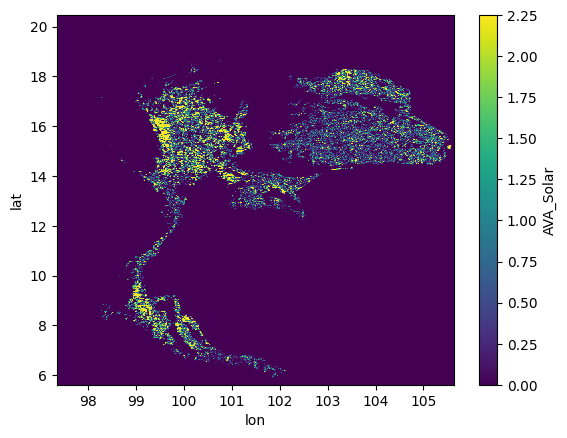

In [43]:
## xr_ref = xr.open_dataset('Output\\xr_final_SI_preped.nc')
xr_ref = xr_final_SI
print(xr_ref)
print("AVA Wind = ",xr_ref['AVA_Wind'].sum())
print("AVA Solar = ",xr_ref['AVA_Solar'].sum())
print('Max SI Wind = ',xr_ref['SI_Wind'].max())
print('Max SI Solar = ',xr_ref['SI_Solar'].max())
xr_ref['AVA_Solar'].plot()

print('coarsenscale = ',coarsenscale)
print('areapergrid = ',areapergrid)
print('mwpergrid_wind = ',mwpergrid_wind)
print('mwpergrid_solar = ',mwpergrid_solar)
print('rollingwindow_spp_wind = ',rollingwindow_spp_wind,' * ',rollingwindow_spp_wind,' = ', mwpergrid_wind * (rollingwindow_spp_wind**2))
print('rollingwindow_vspp_wind = ',rollingwindow_vspp_wind,' * ',rollingwindow_vspp_wind,' = ', mwpergrid_wind * (rollingwindow_vspp_wind**2))
print('rollingwindow_spp_solar = ',rollingwindow_spp_solar,' * ',rollingwindow_spp_solar,' = ', mwpergrid_solar * (rollingwindow_spp_solar**2))
print('rollingwindow_vspp_solar = ',rollingwindow_vspp_solar,' * ',rollingwindow_vspp_solar,' = ', mwpergrid_solar * (rollingwindow_vspp_solar**2))

# ######## PDP ############################################################
# SPP_quota_wind_total =  0
# SPP_quota_wind_R0 = 0
# SPP_quota_wind_R1 = 0
# SPP_quota_wind_R2 = 0
# SPP_quota_wind_R3 =  0
# SPP_quota_wind_R4 =  0

# VSPP_quota_wind_total =  0
# VSPP_quota_wind_R0 =  0
# VSPP_quota_wind_R1 =  0
# VSPP_quota_wind_R2 =  0
# VSPP_quota_wind_R3 =  0
# VSPP_quota_wind_R4 = 0

# SPP_quota_solar_total =  0
# SPP_quota_solar_R0 =  0
# SPP_quota_solar_R1 =  0
# SPP_quota_solar_R2 =  0
# SPP_quota_solar_R3 = 0
# SPP_quota_solar_R4 =  0

# VSPP_quota_solar_total = 0
# VSPP_quota_solar_R0 = 0
# VSPP_quota_solar_R1 =  0
# VSPP_quota_solar_R2 =  0
# VSPP_quota_solar_R3 =   0
# VSPP_quota_solar_R4 =  0
# ######## PDP ############################################################

######## PDP ############################################################
SPP_quota_wind_total =  6335
SPP_quota_wind_R0 = 0
SPP_quota_wind_R1 = 0
SPP_quota_wind_R2 = 6075
SPP_quota_wind_R3 =  260
SPP_quota_wind_R4 =  0

VSPP_quota_wind_total =  0
VSPP_quota_wind_R0 =  0
VSPP_quota_wind_R1 =  0
VSPP_quota_wind_R2 =  0
VSPP_quota_wind_R3 =  0
VSPP_quota_wind_R4 = 0

SPP_quota_solar_total =  18810
SPP_quota_solar_R0 =  0
SPP_quota_solar_R1 =  3150
SPP_quota_solar_R2 =  3060
SPP_quota_solar_R3 = 8100
SPP_quota_solar_R4 =  4500

VSPP_quota_solar_total = 5372
VSPP_quota_solar_R0 = 16
VSPP_quota_solar_R1 =  983
VSPP_quota_solar_R2 =  1929
VSPP_quota_solar_R3 =   725
VSPP_quota_solar_R4 =  1719
######## PDP ############################################################

In [44]:
print("max AVA SPP Wind = ",xr_ref['AVA_Wind'].rolling(lon = rollingwindow_spp_wind, lat = rollingwindow_spp_wind, min_periods=1,center=True).sum().max())
print("max AVA SPP Solar = ",xr_ref['AVA_Solar'].rolling(lon = rollingwindow_spp_solar, lat = rollingwindow_spp_solar, min_periods=1,center=True).sum().max())

max AVA SPP Wind =  <xarray.DataArray 'AVA_Wind' ()>
array(20.25)
max AVA SPP Solar =  <xarray.DataArray 'AVA_Solar' ()>
array(20.25)


In [45]:
######################## model #####################################################
m = linopy.Model()

built_SPP_wind = m.add_variables(integer=True,upper = 1,lower =0, coords=xr_ref.coords, name='built_SPP_wind')
cap_SPP_wind = m.add_variables(lower=0.00, coords=xr_ref.coords, name='cap_SPP_wind')

built_VSPP_wind = m.add_variables(integer=True,upper = 1,lower =0, coords=xr_ref.coords, name='built_VSPP_wind')
cap_VSPP_wind = m.add_variables(lower=0.00, coords=xr_ref.coords, name='cap_VSPP_wind')

built_SPP_solar = m.add_variables(integer=True,upper = 1,lower =0, coords=xr_ref.coords, name='built_SPP_solar')
cap_SPP_solar = m.add_variables(lower=0.00, coords=xr_ref.coords, name='cap_SPP_solar')

built_VSPP_solar = m.add_variables(integer=True,upper = 1,lower =0, coords=xr_ref.coords, name='built_VSPP_solar')
cap_VSPP_solar = m.add_variables(lower=0.00, coords=xr_ref.coords, name='cap_VSPP_solar')

############################################ Constraint Building Location Logic ##############################################################################
constr_built_logic =  m.add_constraints(
(
    built_SPP_wind.rolling(lat = rollingwindow_spp_wind,center=True,min_periods=1).sum().rolling(lon = rollingwindow_spp_wind,center=True,min_periods=1).sum()
    +
    built_VSPP_wind.rolling(lat = rollingwindow_vspp_wind,center=True,min_periods=1).sum().rolling(lon = rollingwindow_vspp_wind,center=True,min_periods=1).sum()
    +
    built_SPP_solar.rolling(lat = rollingwindow_spp_solar,center=True,min_periods=1).sum().rolling(lon = rollingwindow_spp_solar,center=True,min_periods=1).sum()
    +
    built_VSPP_solar.rolling(lat = rollingwindow_vspp_solar,center=True,min_periods=1).sum().rolling(lon = rollingwindow_vspp_solar,center=True,min_periods=1).sum()
)
    <= 1
    , name='constr_built_logic'
)

############################################ Constraint Building Location Logic ##############################################################################

############################################ Constraint Capacity ##############################################################################
constr_maxcap_SPP_wind = m.add_constraints(
    cap_SPP_wind <= (built_SPP_wind) * (mwperkm2_wind * xr_ref['AVA_Wind'].rolling(lon = rollingwindow_spp_wind, lat = rollingwindow_spp_wind, min_periods=1,center=True).sum())
    ,name = 'constr_maxcap_SPP_wind'
)
constr_mincap_SPP_wind = m.add_constraints(
    cap_SPP_wind >= (built_SPP_wind) * 11
    ,name = 'constr_mincap_SPP_wind'
)
constr_maxcap_VSPP_wind = m.add_constraints(
    cap_VSPP_wind <= (built_VSPP_wind) * (mwperkm2_wind * xr_ref['AVA_Wind'].rolling(lon = rollingwindow_vspp_wind, lat = rollingwindow_vspp_wind, min_periods=1,center=True).sum())
    ,name = 'constr_maxcap_VSPP_wind'
)
constr_mincap_VSPP_wind = m.add_constraints(
    cap_VSPP_wind >= (built_VSPP_wind) * 1
    ,name = 'constr_mincap_VSPP_wind'
)

constr_maxcap_SPP_solar = m.add_constraints(
    cap_SPP_solar <= (built_SPP_solar) * (mwperkm2_solar * xr_ref['AVA_Solar'].rolling(lon = rollingwindow_spp_solar, lat = rollingwindow_spp_solar, min_periods=1,center=True).sum())
    ,name = 'constr_maxcap_SPP_solar'
)
constr_mincap_SPP_solar = m.add_constraints(
    cap_SPP_solar >= (built_SPP_solar) * 11
    ,name = 'constr_mincap_SPP_solar'
)
constr_maxcap_VSPP_solar = m.add_constraints(
    cap_VSPP_solar <= (built_VSPP_solar) * (mwperkm2_solar * xr_ref['AVA_Solar'].rolling(lon = rollingwindow_vspp_solar, lat = rollingwindow_vspp_solar, min_periods=1,center=True).sum())
    ,name = 'constr_maxcap_VSPP_solar'
)
constr_mincap_VSPP_solar = m.add_constraints(
    cap_VSPP_solar >= (built_VSPP_solar) * 1
    ,name = 'constr_mincap_VSPP_solar'
)
############################################ Constraint Capacity ##############################################################################

############################################################################################################################################################

constr_SPP_quota_wind = m.add_constraints((cap_SPP_wind.where(xr_ref['SI_Wind'] >= 0.1,drop=True).sum()) >= SPP_quota_wind_total , name='constr_SPP_quota_wind')

constr_SPP_quota_wind_r0 = m.add_constraints(lhs = (cap_SPP_wind).where((xr_ref['SI_Wind'] >= 0.1) & (xr_ref['region'] == 'R0'),drop=True).sum()
                                             , sign = '>=' , rhs = SPP_quota_wind_R0, name='constr_SPP_quota_wind_r0')

constr_SPP_quota_wind_r1 = m.add_constraints(lhs = (cap_SPP_wind).where((xr_ref['SI_Wind'] >= 0.1) & (xr_ref['region'] == 'R1'),drop=True).sum()
                                             , sign = '>=' , rhs = SPP_quota_wind_R1, name='constr_SPP_quota_wind_r1')

constr_SPP_quota_wind_r2 = m.add_constraints(lhs = (cap_SPP_wind).where((xr_ref['SI_Wind'] >= 0.1) & (xr_ref['region'] == 'R2'),drop=True).sum()
                                             , sign = '>=' , rhs = SPP_quota_wind_R2, name='constr_SPP_quota_wind_r2')

constr_SPP_quota_wind_r3 = m.add_constraints(lhs = (cap_SPP_wind).where((xr_ref['SI_Wind'] >= 0.1) & (xr_ref['region'] == 'R3'),drop=True).sum()
                                             , sign = '>=' , rhs = SPP_quota_wind_R3, name='constr_SPP_quota_wind_r3')

constr_SPP_quota_wind_r4 = m.add_constraints(lhs = (cap_SPP_wind).where((xr_ref['SI_Wind'] >= 0.1) & (xr_ref['region'] == 'R4'),drop=True).sum()
                                             , sign = '>=' , rhs = SPP_quota_wind_R4, name='constr_SPP_quota_wind_r4')

############################################################################################################################################################

constr_VSPP_quota_wind = m.add_constraints((cap_VSPP_wind.where(xr_ref['SI_Wind'] >= 0.1,drop=True).sum()) >= VSPP_quota_wind_total , name='constr_VSPP_quota_wind')

constr_VSPP_quota_wind_r0 = m.add_constraints(lhs = (cap_VSPP_wind).where((xr_ref['SI_Wind'] >= 0.1) & (xr_ref['region'] == 'R0'),drop=True).sum()
                                             , sign = '>=' , rhs = VSPP_quota_wind_R0, name='constr_VSPP_quota_wind_r0')

constr_VSPP_quota_wind_r1 = m.add_constraints(lhs = (cap_VSPP_wind).where((xr_ref['SI_Wind'] >= 0.1) & (xr_ref['region'] == 'R1'),drop=True).sum()
                                             , sign = '>=' , rhs = VSPP_quota_wind_R1, name='constr_VSPP_quota_wind_r1')

constr_VSPP_quota_wind_r2 = m.add_constraints(lhs = (cap_VSPP_wind).where((xr_ref['SI_Wind'] >= 0.1) & (xr_ref['region'] == 'R2'),drop=True).sum()
                                             , sign = '>=' , rhs = VSPP_quota_wind_R2, name='constr_VSPP_quota_wind_r2')

constr_VSPP_quota_wind_r3 = m.add_constraints(lhs = (cap_VSPP_wind).where((xr_ref['SI_Wind'] >= 0.1) & (xr_ref['region'] == 'R3'),drop=True).sum()
                                             , sign = '>=' , rhs = VSPP_quota_wind_R3, name='constr_VSPP_quota_wind_r3')

constr_VSPP_quota_wind_r4 = m.add_constraints(lhs = (cap_VSPP_wind).where((xr_ref['SI_Wind'] >= 0.1) & (xr_ref['region'] == 'R4'),drop=True).sum()
                                             , sign = '>=' , rhs = VSPP_quota_wind_R4, name='constr_VSPP_quota_wind_r4')
############################################################################################################################################################

constr_SPP_quota_solar = m.add_constraints((cap_SPP_solar.where(xr_ref['SI_Solar'] >= 0.1,drop=True).sum()) >= SPP_quota_solar_total, name='constr_SPP_quota_solar')

constr_SPP_quota_solar_r0 = m.add_constraints(lhs = (cap_SPP_solar).where((xr_ref['SI_Solar'] >= 0.1) & (xr_ref['region'] == 'R0'),drop=True).sum()
                                             , sign = '>=' , rhs = SPP_quota_solar_R0, name='constr_SPP_quota_solar_r0')

constr_SPP_quota_solar_r1 = m.add_constraints(lhs = (cap_SPP_solar).where((xr_ref['SI_Solar'] >= 0.1) & (xr_ref['region'] == 'R1'),drop=True).sum()
                                             , sign = '>=' , rhs = SPP_quota_solar_R1, name='constr_SPP_quota_solar_r1')

constr_SPP_quota_solar_r2 = m.add_constraints(lhs = (cap_SPP_solar).where((xr_ref['SI_Solar'] >= 0.1) & (xr_ref['region'] == 'R2'),drop=True).sum()
                                             , sign = '>=' , rhs = SPP_quota_solar_R2, name='constr_SPP_quota_solar_r2')

constr_SPP_quota_solar_r3 = m.add_constraints(lhs = (cap_SPP_solar).where((xr_ref['SI_Solar'] >= 0.1) & (xr_ref['region'] == 'R3'),drop=True).sum()
                                             , sign = '>=' , rhs = SPP_quota_solar_R3, name='constr_SPP_quota_solar_r3')

constr_SPP_quota_solar_r4 = m.add_constraints(lhs = (cap_SPP_solar).where((xr_ref['SI_Solar'] >= 0.1) & (xr_ref['region'] == 'R4'),drop=True).sum()
                                             , sign = '>=' , rhs = SPP_quota_solar_R4, name='constr_SPP_quota_solar_r4')

############################################################################################################################################################

constr_VSPP_quota_solar = m.add_constraints((cap_VSPP_solar.where(xr_ref['SI_Solar'] >= 0.1,drop=True).sum()) >= VSPP_quota_solar_total, name='constr_VSPP_quota_solar')

constr_VSPP_quota_solar_r0 = m.add_constraints(lhs = (cap_VSPP_solar).where((xr_ref['SI_Solar'] >= 0.1) & (xr_ref['region'] == 'R0'),drop=True).sum()
                                             , sign = '>=' , rhs = VSPP_quota_solar_R0, name='constr_VSPP_quota_solar_r0')

constr_VSPP_quota_solar_r1 = m.add_constraints(lhs = (cap_VSPP_solar).where((xr_ref['SI_Solar'] >= 0.1) & (xr_ref['region'] == 'R1'),drop=True).sum()
                                             , sign = '>=' , rhs = VSPP_quota_solar_R1, name='constr_VSPP_quota_solar_r1')

constr_VSPP_quota_solar_r2 = m.add_constraints(lhs = (cap_VSPP_solar).where((xr_ref['SI_Solar'] >= 0.1) & (xr_ref['region'] == 'R2'),drop=True).sum()
                                             , sign = '>=' , rhs = VSPP_quota_solar_R2, name='constr_VSPP_quota_solar_r2')

constr_VSPP_quota_solar_r3 = m.add_constraints(lhs = (cap_VSPP_solar).where((xr_ref['SI_Solar'] >= 0.1) & (xr_ref['region'] == 'R3'),drop=True).sum()
                                             , sign = '>=' , rhs = VSPP_quota_solar_R3, name='constr_VSPP_quota_solar_r3')

constr_VSPP_quota_solar_r4 = m.add_constraints(lhs = (cap_VSPP_solar).where((xr_ref['SI_Solar'] >= 0.1) & (xr_ref['region'] == 'R4'),drop=True).sum()
                                             , sign = '>=' , rhs = VSPP_quota_solar_R4, name='constr_VSPP_quota_solar_r4')

############################################################################################################################################################

In [46]:
obj = (-1000) * (
    ( 
     xr_ref['SI_Wind'].rolling(lon = rollingwindow_spp_wind, lat = rollingwindow_spp_wind, min_periods=1,center=True).sum()
     * (cap_SPP_wind) 
     / (mwpergrid_wind * (rollingwindow_spp_wind**2))
     )
    +
    ( 
     xr_ref['SI_Wind'].rolling(lon = rollingwindow_vspp_wind, lat = rollingwindow_vspp_wind, min_periods=1,center=True).sum()
     * (cap_VSPP_wind) 
     / (mwpergrid_wind * (rollingwindow_vspp_wind**2))
     )
    +
    ( 
     xr_ref['SI_Solar'].rolling(lon = rollingwindow_spp_solar, lat = rollingwindow_spp_solar, min_periods=1,center=True).sum()
     * (cap_SPP_solar) 
     / (mwpergrid_solar * (rollingwindow_spp_solar**2))
     )
    +
    ( 
     xr_ref['SI_Solar'].rolling(lon = rollingwindow_vspp_solar, lat = rollingwindow_vspp_solar, min_periods=1,center=True).sum()
     * (cap_VSPP_solar) 
     / (mwpergrid_solar * (rollingwindow_vspp_solar**2))
     )
)

m.add_objective(obj)

In [47]:
print("presolve = ",m)
m.solve(solver_name='highs',
        # mip_abs_gap = 0.002,
        # mip_rel_gap = 0.002,
        )

print('aftersolve = ',m)
solution = m.solution
solution = solution.fillna(0)
print(solution)

presolve =  Linopy MILP model

Variables:
----------
 * built_SPP_wind (lat, lon)
 * cap_SPP_wind (lat, lon)
 * built_VSPP_wind (lat, lon)
 * cap_VSPP_wind (lat, lon)
 * built_SPP_solar (lat, lon)
 * cap_SPP_solar (lat, lon)
 * built_VSPP_solar (lat, lon)
 * cap_VSPP_solar (lat, lon)

Constraints:
------------
 * constr_built_logic (lat, lon)
 * constr_maxcap_SPP_wind (lat, lon)
 * constr_mincap_SPP_wind (lat, lon)
 * constr_maxcap_VSPP_wind (lat, lon)
 * constr_mincap_VSPP_wind (lat, lon)
 * constr_maxcap_SPP_solar (lat, lon)
 * constr_mincap_SPP_solar (lat, lon)
 * constr_maxcap_VSPP_solar (lat, lon)
 * constr_mincap_VSPP_solar (lat, lon)
 * constr_SPP_quota_wind
 * constr_SPP_quota_wind_r0
 * constr_SPP_quota_wind_r1
 * constr_SPP_quota_wind_r2
 * constr_SPP_quota_wind_r3
 * constr_SPP_quota_wind_r4
 * constr_VSPP_quota_wind
 * constr_VSPP_quota_wind_r0
 * constr_VSPP_quota_wind_r1
 * constr_VSPP_quota_wind_r2
 * constr_VSPP_quota_wind_r3
 * constr_VSPP_quota_wind_r4
 * constr_SPP_q

Writing integer variables.: 100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


aftersolve =  Linopy MILP model

Variables:
----------
 * built_SPP_wind (lat, lon)
 * cap_SPP_wind (lat, lon)
 * built_VSPP_wind (lat, lon)
 * cap_VSPP_wind (lat, lon)
 * built_SPP_solar (lat, lon)
 * cap_SPP_solar (lat, lon)
 * built_VSPP_solar (lat, lon)
 * cap_VSPP_solar (lat, lon)

Constraints:
------------
 * constr_built_logic (lat, lon)
 * constr_maxcap_SPP_wind (lat, lon)
 * constr_mincap_SPP_wind (lat, lon)
 * constr_maxcap_VSPP_wind (lat, lon)
 * constr_mincap_VSPP_wind (lat, lon)
 * constr_maxcap_SPP_solar (lat, lon)
 * constr_mincap_SPP_solar (lat, lon)
 * constr_maxcap_VSPP_solar (lat, lon)
 * constr_mincap_VSPP_solar (lat, lon)
 * constr_SPP_quota_wind
 * constr_SPP_quota_wind_r0
 * constr_SPP_quota_wind_r1
 * constr_SPP_quota_wind_r2
 * constr_SPP_quota_wind_r3
 * constr_SPP_quota_wind_r4
 * constr_VSPP_quota_wind
 * constr_VSPP_quota_wind_r0
 * constr_VSPP_quota_wind_r1
 * constr_VSPP_quota_wind_r2
 * constr_VSPP_quota_wind_r3
 * constr_VSPP_quota_wind_r4
 * constr_SPP

In [48]:
xr_ref['cap_SPP_wind'] = solution['cap_SPP_wind'] * solution['built_SPP_wind']
xr_ref['cap_VSPP_wind'] = solution['cap_VSPP_wind'] * solution['built_VSPP_wind']
xr_ref['cap_SPP_solar'] = solution['cap_SPP_solar'] * solution['built_SPP_solar']
xr_ref['cap_VSPP_solar'] = solution['cap_VSPP_solar'] * solution['built_VSPP_solar']

print("cap_SPP_wind = ",xr_ref['cap_SPP_wind'].sum())
print("cap_VSPP_wind = ",xr_ref['cap_VSPP_wind'].sum())
print("cap_SPP_solar = ",xr_ref['cap_SPP_solar'].sum())
print("cap_VSPP_solar = ",xr_ref['cap_VSPP_solar'].sum())
print(xr_ref.data_vars)
xr_ref.to_netcdf(path='Output\\xr_output.nc')

cap_SPP_wind =  <xarray.DataArray 'cap_SPP_wind' ()>
array(6992.3251934)
cap_VSPP_wind =  <xarray.DataArray 'cap_VSPP_wind' ()>
array(19880.64048803)
cap_SPP_solar =  <xarray.DataArray 'cap_SPP_solar' ()>
array(29705.39983654)
cap_VSPP_solar =  <xarray.DataArray 'cap_VSPP_solar' ()>
array(920905.22868929)
Data variables:
    SI_Solar        (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    SI_Wind         (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    AVA_Wind        (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    AVA_Solar       (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    SI_Wind_max     (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    SI_Wind_min     (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    SI_Solar_max    (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    SI_Solar_min    (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ADM1_EN         (lat, lon) object 'Phuket

c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


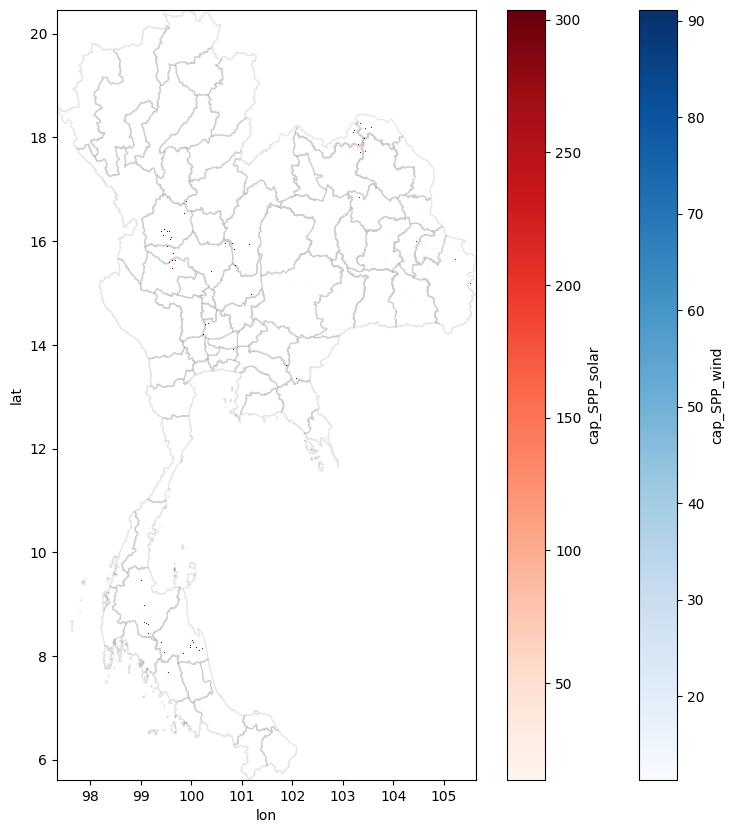

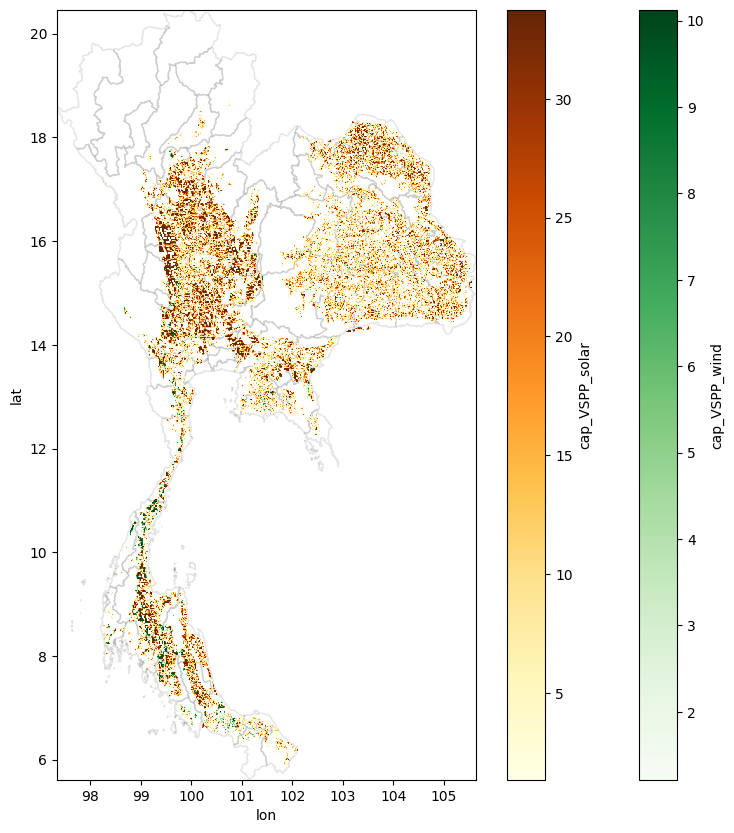

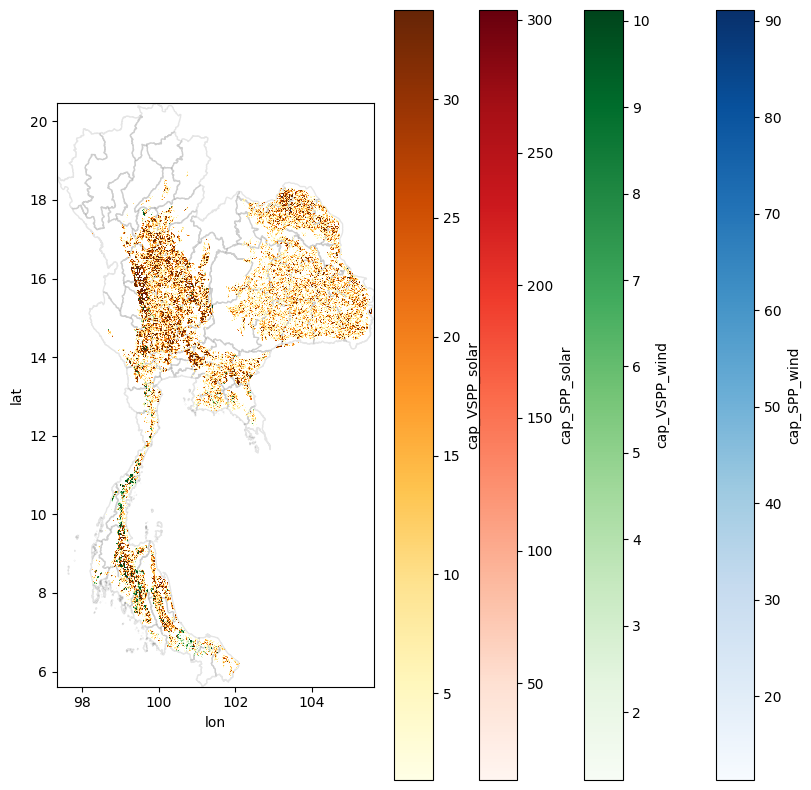

In [49]:
thailandmap = gpd.read_file('Data\\tha_admbnda_adm1_rtsd_20220121\\tha_admbnda_adm1_rtsd_20220121.shp')
thailandmap.crs = {'init': 'epsg:4326'}

fig, ax = plt.subplots(figsize=(10,10))
thailandmap.plot(ax = ax, color='none', edgecolor = 'black', zorder = 0,alpha = 0.1)
xr_ref['cap_SPP_wind'].where(xr_ref['cap_SPP_wind']>0).plot(ax = ax,zorder = 1,cmap="Blues")
xr_ref['cap_SPP_solar'].where(xr_ref['cap_SPP_solar']>0).plot(ax = ax,zorder = 3,cmap="Reds")

fig2, ax2 = plt.subplots(figsize=(10,10))
thailandmap.plot(ax = ax2, color='none', edgecolor = 'black', zorder = 0,alpha = 0.1)
xr_ref['cap_VSPP_wind'].where(xr_ref['cap_VSPP_wind']>0).plot(ax = ax2,zorder = 2,cmap="Greens")
xr_ref['cap_VSPP_solar'].where(xr_ref['cap_VSPP_solar']>0).plot(ax = ax2,zorder = 4,cmap="YlOrBr")

fig3, ax3 = plt.subplots(figsize=(10,10))
thailandmap.plot(ax = ax3, color='none', edgecolor = 'black', zorder = 0,alpha = 0.1)
xr_ref['cap_SPP_wind'].where(xr_ref['cap_SPP_wind']>0).plot(ax = ax3,zorder = 1,cmap="Blues")
xr_ref['cap_VSPP_wind'].where(xr_ref['cap_VSPP_wind']>0).plot(ax = ax3,zorder = 2,cmap="Greens")
xr_ref['cap_SPP_solar'].where(xr_ref['cap_SPP_solar']>0).plot(ax = ax3,zorder = 3,cmap="Reds")
xr_ref['cap_VSPP_solar'].where(xr_ref['cap_VSPP_solar']>0).plot(ax = ax3,zorder = 4,cmap="YlOrBr")

In [50]:
province = "Kalasin"
province = thailandmap.loc[thailandmap['ADM1_EN'] == province]
print(province.unary_union.bounds)
min_lon = province.unary_union.bounds[0]
max_lon = province.unary_union.bounds[2]
max_lat = province.unary_union.bounds[3]
min_lat = province.unary_union.bounds[1]

(103.09676066900005, 16.181673239000077, 104.24064016800008, 17.101957866000078)


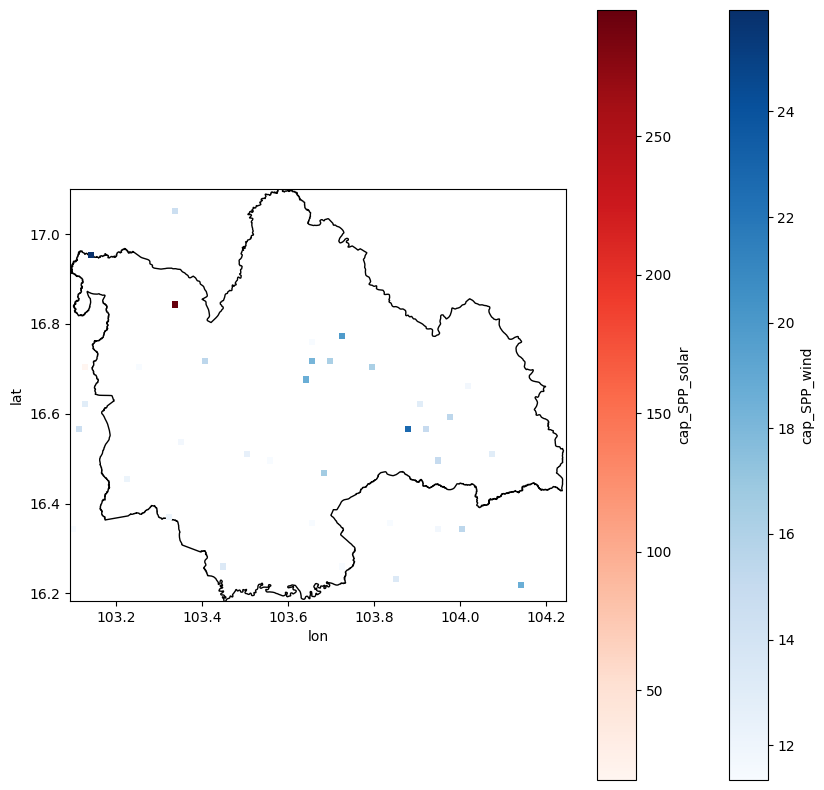

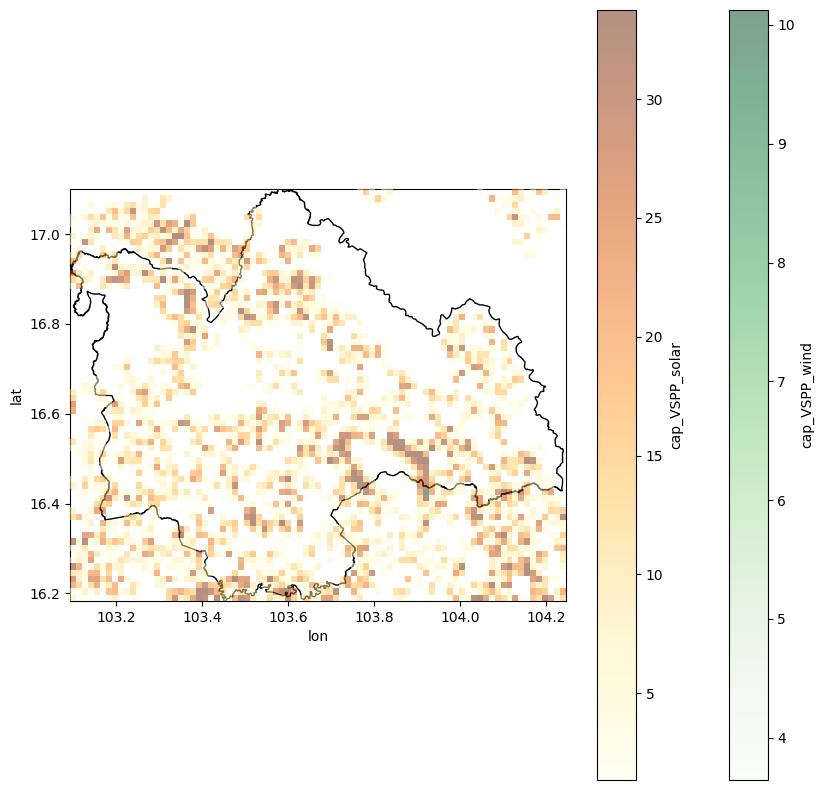

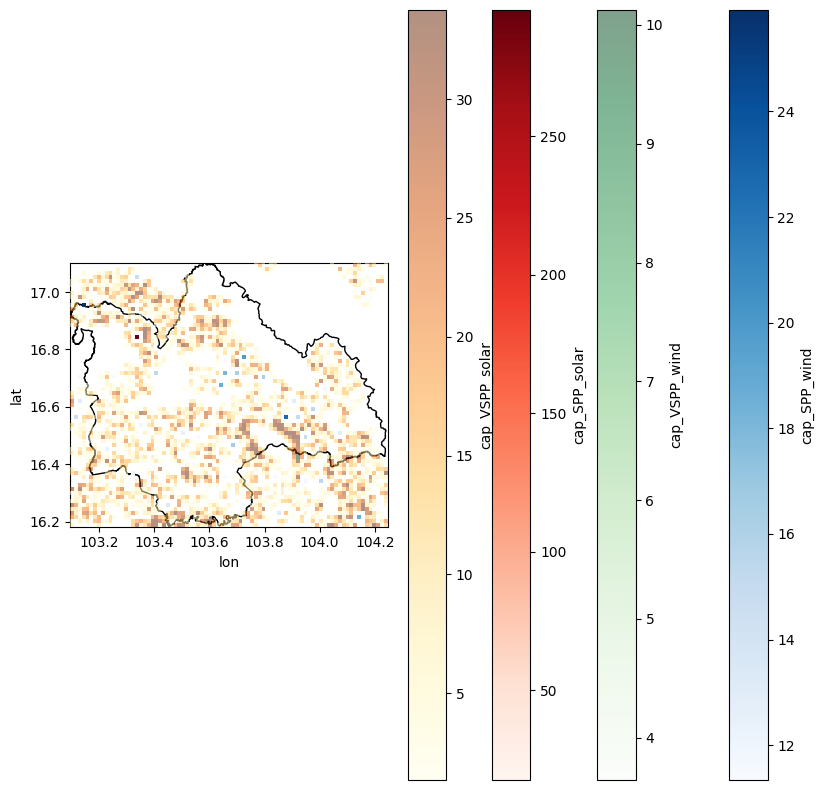

In [51]:
xr_buffer = xr_ref.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))
# print(xr_buffer)

fig, ax = plt.subplots(figsize=(10,10))
province.plot(ax = ax, color='none', edgecolor = 'black', zorder = 0)
xr_buffer['cap_SPP_wind'].where(xr_buffer['cap_SPP_wind']>0).plot(ax = ax,zorder = 1,cmap="Blues")
xr_buffer['cap_SPP_solar'].where(xr_buffer['cap_SPP_solar']>0).plot(ax = ax,zorder = 3,cmap="Reds")

fig2, ax2 = plt.subplots(figsize=(10,10))
province.plot(ax = ax2, color='none', edgecolor = 'black', zorder = 0)
xr_buffer['cap_VSPP_wind'].where(xr_buffer['cap_VSPP_wind']>0).plot(ax = ax2,zorder = 2,cmap="Greens",alpha = 0.5)
xr_buffer['cap_VSPP_solar'].where(xr_buffer['cap_VSPP_solar']>0).plot(ax = ax2,zorder = 4,cmap="YlOrBr",alpha = 0.5)

fig3, ax3 = plt.subplots(figsize=(10,10))
province.plot(ax = ax3, color='none', edgecolor = 'black', zorder = 0)
xr_buffer['cap_SPP_wind'].where(xr_buffer['cap_SPP_wind']>0).plot(ax = ax3,zorder = 1,cmap="Blues")
xr_buffer['cap_VSPP_wind'].where(xr_buffer['cap_VSPP_wind']>0).plot(ax = ax3,zorder = 2,cmap="Greens",alpha = 0.5)
xr_buffer['cap_SPP_solar'].where(xr_buffer['cap_SPP_solar']>0).plot(ax = ax3,zorder = 3,cmap="Reds")
xr_buffer['cap_VSPP_solar'].where(xr_buffer['cap_VSPP_solar']>0).plot(ax = ax3,zorder = 4,cmap="YlOrBr",alpha = 0.5)